# EDA

In [4]:
import os
import fitz  # PyMuPDF
import pdfplumber
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from langdetect import detect
from wordcloud import WordCloud

In [15]:
import logging
import pdfplumber

# Suppress pdfminer logs
logging.getLogger("pdfminer").setLevel(logging.ERROR)

In [17]:
def analyze_pdf(path):
    try:
        doc = fitz.open(path)
        metadata = doc.metadata
        num_pages = len(doc)

        total_chars = 0
        text_pages, image_pages = 0, 0
        languages = []

        with pdfplumber.open(path) as pdf:
            for page in pdf.pages:
                text = page.extract_text()
                if text and text.strip():
                    total_chars += len(text)
                    text_pages += 1
                    try:
                        lang = detect(text[:500])
                        languages.append(lang)
                    except:
                        pass
                else:
                    image_pages += 1

        return {
            "file": os.path.basename(path),
            "pages": num_pages,
            "text_pages": text_pages,
            "image_pages": image_pages,
            "character_count": total_chars,
            "language": max(set(languages), key=languages.count) if languages else "unknown",
            "title": metadata.get("title", ""),
            "author": metadata.get("author", ""),
            "producer": metadata.get("producer", ""),
            "file_size_kb": os.path.getsize(path) / 1024
        }
    except Exception as e:
        return {"file": os.path.basename(path), "error": str(e)}

In [19]:
pdf_dir = "../data/raw_data/"  # e.g., "./pdf_docs"
results = []

for file in tqdm(os.listdir(pdf_dir)):
    if file.lower().endswith(".pdf"):
        full_path = os.path.join(pdf_dir, file)
        results.append(analyze_pdf(full_path))

df = pd.DataFrame(results)
df.to_csv("pdf_eda_summary.csv", index=False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1170/1170 [10:09<00:00,  1.92it/s]


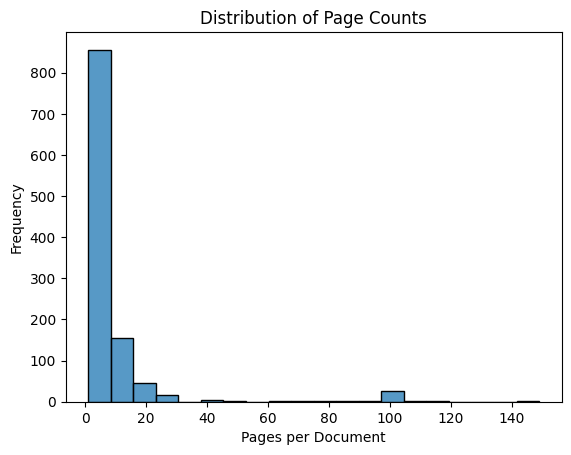

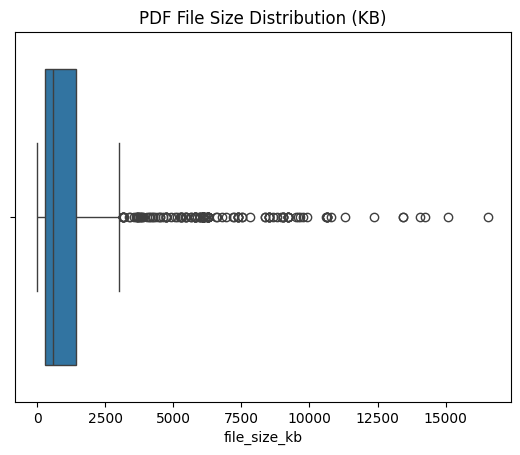

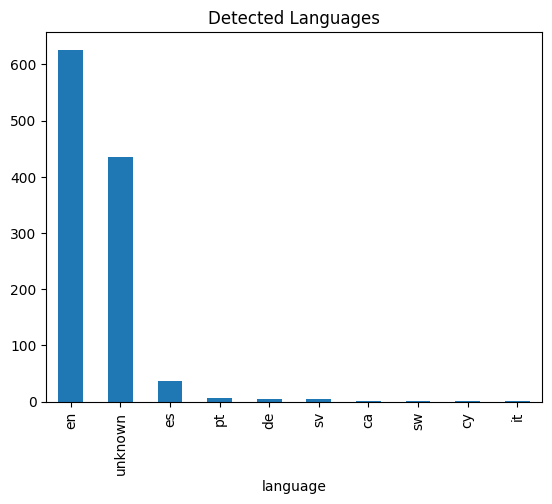

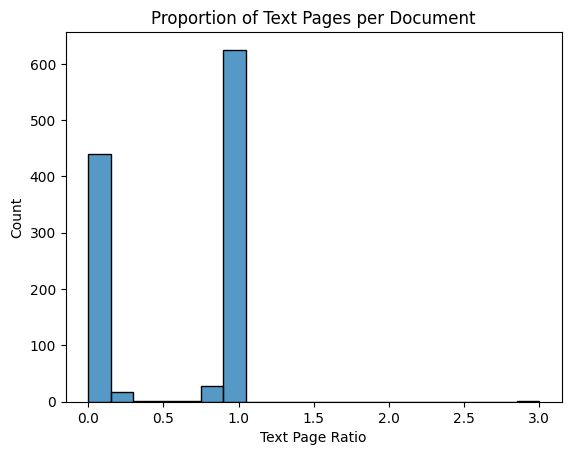

In [21]:
sns.histplot(df["pages"], bins=20)
plt.title("Distribution of Page Counts")
plt.xlabel("Pages per Document")
plt.ylabel("Frequency")
plt.show()

sns.boxplot(x=df["file_size_kb"])
plt.title("PDF File Size Distribution (KB)")
plt.show()

df["language"].value_counts().plot(kind='bar', title="Detected Languages")
plt.show()

text_ratio = df["text_pages"] / df["pages"]
sns.histplot(text_ratio, bins=20)
plt.title("Proportion of Text Pages per Document")
plt.xlabel("Text Page Ratio")
plt.show()

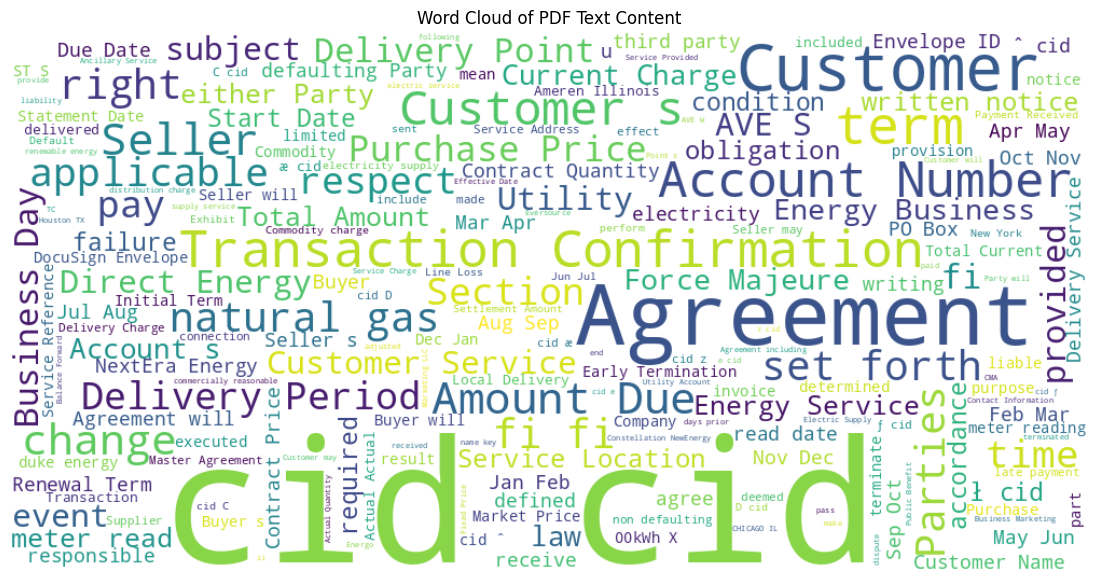

In [23]:
all_text = ""
for file in df["file"]:
    path = os.path.join(pdf_dir, file)
    try:
        with pdfplumber.open(path) as pdf:
            for page in pdf.pages:
                text = page.extract_text()
                if text:
                    all_text += text + " "
    except:
        continue

wordcloud = WordCloud(width=1000, height=500, background_color="white").generate(all_text)
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of PDF Text Content")
plt.show()